In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
import krippendorff
import ktrain
from ktrain import text as ktext

In [3]:
!pip install torchsummary
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load and merge data files

In [4]:
# Read and combine croudsourced_data csv
file_list = glob('./Dataset/crowdsourced_data/*/*.csv')
print(len(file_list))
data_df = pd.concat ([ pd.read_csv(file) for file in file_list ])

29


### Sample Data

In [5]:
data_df.head()
print(len(set(data_df['questionId'].values)))

1066


### Data statistics

Unique questions by 'questionId' column: 1066
Unique questions by 'Question' column: 1105 

Duplicate Questions: 2876
Questions without duplicates: 22


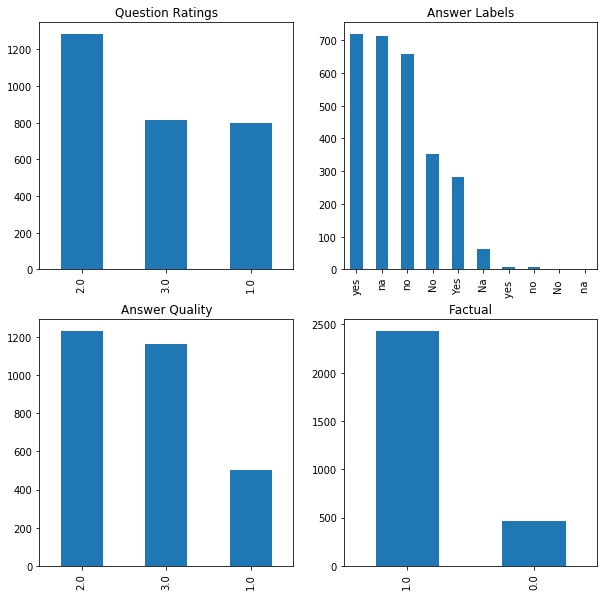

In [6]:
# Unique Questions
unique_questions_byid = len(set(data_df['questionId'].values))
unique_questions_bytext = len(set(data_df['Question'].values))
print('Unique questions by \'questionId\' column:',unique_questions_byid)
print('Unique questions by \'Question\' column:',unique_questions_bytext,'\n')

# Total Questions having duplicates
duplicate_df = data_df[data_df.duplicated(subset = ['questionId'], keep = False)]
non_duplicate_df = data_df[~data_df.duplicated(subset = ['questionId'], keep = False)]
print('Duplicate Questions:', duplicate_df.shape[0])
print('Questions without duplicates:',non_duplicate_df.shape[0])

# Distribution of Question Ratings
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10))
pd.Series(data_df['Question Rating'].values).value_counts().plot(kind = 'bar', title = 'Question Ratings', ax = axs[0,0])
pd.Series(data_df['Answer Label'].values).value_counts().plot(kind ='bar', title = 'Answer Labels', ax = axs[0,1])
pd.Series(data_df['Answer Quality'].values).value_counts().plot(kind ='bar', title = 'Answer Quality', ax = axs[1,0])
pd.Series(data_df['Factual'].values).value_counts().plot(kind ='bar', title = 'Factual', ax = axs[1,1])
plt.savefig('disp.png')

### Observations
- The amount of unique questions by __[questionId]__ is less than the amount of unique questions by __[question]__. This points to the possibility that there may be differences among questions with same __[questionId]__.
- The distribution of answer labels shows a wider distribution due to __non-uniform labels__.

#### The reasons for these observations are explored below.

In [7]:
#Group duplicate data by {questionId}
grouped = data_df.groupby(['questionId'])

#Iterate over the duplicate groups
for ques_id,group in grouped:
    
    # Group based on question text
    grouped_bytext = group.groupby(['Question'])
    if len(grouped_bytext) != 1:
        print('questionId:',ques_id, 'Length:',len(group['Question'].values))
        print(*group['Question'].values,'\n',sep='\n')
        

questionId: 156 Length: 2
Is perfect pitch something you're "born with?",https://skeptics.stackexchange.com/questions/3274#3281,,,,
"Can blood group affect behavior?
Can blood group affect behavior?


questionId: 814 Length: 3
Can a second Chernobyl" happen at the nuclear reactors damaged by the tsunami in Japan?"
Can a "second Chernobyl" happen at the nuclear reactors damaged by the tsunami in Japan?
Can a second Chernobyl" happen at the nuclear reactors damaged by the tsunami in Japan?"


questionId: 2495 Length: 3
Do we need "hot" breakfast food?
Do we need hot" breakfast food?"
Do we need hot" breakfast food?"


questionId: 3373 Length: 3
Do murderers have "the eyes of a killer"?
Do murderers have the eyes of a killer"?"
Do murderers have the eyes of a killer"?"


questionId: 4348 Length: 3
Is there "vastly more matter than anti-matter" in the Universe?
Is there vastly more matter than anti-matter" in the Universe?"
Is there vastly more matter than anti-matter" in the Universe?"




#### We can make the further observations:
- There are badly formed questions with _questionIds {44749, 156}_.
- Presence of special characters like: __" Ô, Ç, Ø__
- Presence of white-space around the question text 
- Presence of an nan

#### The special characters and extra whitespace within question text can be removed as follows. We also make all the Answer Labels to a lowercase.

In [8]:
# Process the dataset based on above observations
# Remove special characters and white space
data_df.loc[:,'Question'] = data_df['Question'].str.replace('"|Ô|Ç|Ø|Â|”|“|,|£','', regex = True).str.strip()

# Conver all answer labels to lower-case
data_df.loc[:,'Answer Label'] = data_df['Answer Label'].str.lower().str.strip()

In [9]:
# Remove nan value
values = {'Answer Label': 'na'}
data_df = data_df.fillna(value=values)

In [10]:
#Group duplicate data by {questionId}
grouped = data_df.groupby(['questionId'])

#Iterate over the duplicate groups
for ques_id,group in grouped:
    
    # Group based on question text
    grouped_bytext = group.groupby(['Question'])
    if len(grouped_bytext) != 1:
        print('questionId:',ques_id, 'Length:',len(group['Question'].values))
        print(*group['Question'].values,'\n',sep='\n')

questionId: 156 Length: 2
Is perfect pitch something you're born with?https://skeptics.stackexchange.com/questions/3274#3281
Can blood group affect behavior?
Can blood group affect behavior?


questionId: 42915 Length: 2
Does General Relativity bring Cosmic Time
Does General Relativity bring Cosmic Time  which is the same for all frames-of-reference?


questionId: 44749 Length: 3
Does one SUV tank of ethanol take as much grain as could feed a person for a whole year?https://skeptics.stackexchange.com/questions/41943#41944
Does sunflower oil reduce LDL (bad) cholesterol more than olive oil?
Does sunflower oil reduce LDL (bad) cholesterol more than olive oil?
Does sunflower oil reduce LDL (bad) cholesterol more than olive oil?




#### The above can be fixed by: 
- Dropping the malformed rows
- Adding the missing value

In [11]:
# We can drop the columns containing malformed data
_str1 = "Is perfect pitch something you're born with?https://skeptics.stackexchange.com/questions/3274#3281 Can blood group affect behavior?"
_str2 = "Does one SUV tank of ethanol take as much grain as could feed a person for a whole year?https://skeptics.stackexchange.com/questions/41943#41944 Does sunflower oil reduce LDL (bad) cholesterol more than olive oil?"
data_df = data_df[~data_df['Question'].str.replace('\n',' ').isin([_str1,_str2])]

# Modify the record that can be fixed
_str3 = "Does General Relativity bring Cosmic Time"
data_df.loc[data_df['Question'] == _str3,'Question'] = "Does General Relativity bring Cosmic Time  which is the same for all frames-of-reference?"

C:\Users\PurusharthGPC\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### The unique questions obtained should now be of the same length, from both 'questionId' and 'Question' text. 

In [12]:
# Unique Questions
unique_questions_byid = len(set(data_df['questionId'].values))
unique_questions_bytext = len(set(data_df['Question'].values))
print('Unique questions by \'questionId\' column:',unique_questions_byid)
print('Unique questions by \'Question\' column:',unique_questions_bytext,'\n')
print('Shape of data_df:',data_df.shape)

Unique questions by 'questionId' column: 1066
Unique questions by 'Question' column: 1066 

Shape of data_df: (2896, 7)


### Finally, we recompute the statistics to see how the distribution has changed.

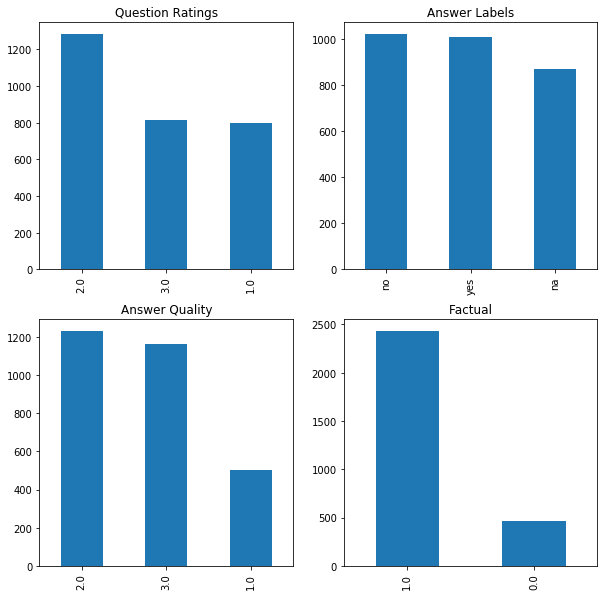

In [13]:
# Distribution of Question Ratings
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10))
pd.Series(data_df['Question Rating'].values).value_counts().plot(kind = 'bar', title = 'Question Ratings', ax = axs[0,0])
pd.Series(data_df['Answer Label'].values).value_counts().plot(kind = 'bar', title = 'Answer Labels', ax = axs[0,1])
pd.Series(data_df['Answer Quality'].values).value_counts().plot(kind ='bar', title = 'Answer Quality', ax = axs[1,0])
pd.Series(data_df['Factual'].values).value_counts().plot(kind = 'bar', title = 'Factual', ax = axs[1,1])

### Now that the data has been cleaned, we further perform the following steps:
- Perform majority voting on duplicate Question entries
- Delete all non-factual questions

In [14]:
data_df.head()

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId
0,Does Bioptron VIP (Visible Incoherent Polarize...,https://skeptics.stackexchange.com/questions/5...,na,1.0,2.0,1.0,5017
1,Is Halal meat healthier to consume?,https://skeptics.stackexchange.com/questions/1...,no,2.0,1.0,1.0,18628
2,Does catnip treat headache and coughs and inso...,https://skeptics.stackexchange.com/questions/7...,na,1.0,2.0,1.0,7367
3,Is climate change currently good for the world...,https://skeptics.stackexchange.com/questions/1...,no,2.0,3.0,1.0,18136
4,Does cooking with extra virgin olive oil cause...,https://skeptics.stackexchange.com/questions/1...,no,2.0,2.0,1.0,19180


In [15]:
# Initialize an empty dataframe
majority_df = pd.DataFrame(columns=data_df.columns)

# Group-by and iterate data_df
grouped = data_df.groupby(['questionId'])
count = 0

#Iterate over the duplicate groups
for ques_id,group in grouped:
    
    # If no duplicate present
    if len(group) == 1:
        # Append to majority_df
        majority_df = pd.concat([majority_df, group])
        
    else:
        factual = stats.mode(group['Factual'].values)[0][0]
        ans_label = stats.mode(group['Answer Label'].values)[0][0]
        ques_rating = np.mean(group['Question Rating'].values.astype(float))
        ans_quality = np.mean(group['Answer Quality'].values.astype(float))
        
        # Append to majority_df
        question = group['Question'].values[0]
        url = group['Answer URL'].values[0]
        majority_df = majority_df.append(
            {'Question':question, 'Answer Label':ans_label,'Question Rating':ques_rating, 'Answer Quality':ans_quality,'Factual':factual,'questionId':ques_id,'Answer URL':url}, ignore_index = True)
        
        

In [103]:
# Delete all non-factual questions
majority_df = majority_df[majority_df['Factual'] == 1.0]

In [104]:
majority_df.shape

(923, 7)

In [18]:
majority_df.head()

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId
0,Does water have a memory as claimed in homeopa...,https://skeptics.stackexchange.com/questions/2#27,no,1.666667,2.333333,1.0,2
1,Does chamomile help you to relax?,https://skeptics.stackexchange.com/questions/3...,na,2.000000,2.000000,1.0,3
2,Are there benefits to the ECA stack for body-b...,https://skeptics.stackexchange.com/questions/2...,yes,1.666667,2.000000,1.0,22
3,Can positive thinking provide an improved outc...,https://skeptics.stackexchange.com/questions/2...,yes,2.666667,2.666667,1.0,26
4,Are vegetables good for me?,https://skeptics.stackexchange.com/questions/3...,yes,2.000000,2.333333,1.0,32


### Now, we compute the inter-rater reliability

In [19]:
# Load data
file_list = glob('./Dataset/crowdsourced_data/*/*.csv')
user_dict = { file.split('\\')[-1].split('.')[0]:pd.read_csv(file) for file in file_list }

# Clean each data_dict
clean_questionIds = list(set(data_df['questionId'].values))

# Answer labels
label_dict = {'yes':2, 'no':1, 'na':0}

# Clean for questionIds
for user in user_dict:
    user_df = user_dict[user]
    
    # Clean data
    user_df = user_df[(user_df['questionId'].isin(clean_questionIds))]
    user_df.loc[:,'Answer Label'] = user_df['Answer Label'].str.lower().str.strip()
    user_df.loc[:,'Answer Label'] = user_df['Answer Label'].map(label_dict)
    user_dict[user] = user_df
    
# Create user matrix for ratings
rating_mat = np.ones((len(user_dict),len(clean_questionIds))) * np.nan

#Answer Label	Question Rating	Answer Quality	Factual
key_list = ['Answer Label', 'Factual', 'Question Rating', 'Answer Quality']

for current_key in key_list:

    # Iterate over users and fill the matrix
    for i,user in enumerate(user_dict):

        # Get user data
        user_df = user_dict[user]
        user_questions = list(user_df['questionId'].values)
        user_ratings = list(user_df[current_key].values)

        # Fill rating_mat
        for j,ques in enumerate(clean_questionIds):

            if ques in user_questions:
                rating_mat[i,j] = user_ratings[user_questions.index(ques)]

    print(current_key, krippendorff.alpha(rating_mat))


    

Answer Label 0.35229521492968385
Factual 0.053187086092715274
Question Rating 0.06762494449406009
Answer Quality 0.17461897185164588


In [20]:
import string
def preprocess_text(df):    

    # remove leading/trailing spaces
    df = df.str.strip()
    
    # convert to lowercase
    df = df.str.lower()
    
    df = df.replace(to_replace ='http\S+', value = '', regex = True)
    
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation) 
    df = df.str.translate(translator)
    
    # remove non-alphanumeric characters
    df = df.replace(to_replace ='\s*[^A-Za-z0-9]+\s*', value = ' ', regex = True)
    
    # remove digits
    translator = str.maketrans('', '', string.digits) 
    df = df.str.translate(translator)
    
    df = df.str.strip()
    
    #lemmatize
    #df = df.apply(lemmatize_text)
    
    return df

In [21]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return (' '.join(lemmatizer.lemmatize(w) for w in word_tokenize(text)))

### Now train an answer detector

In [22]:
# Load the Questions dataset
ques_df = pd.read_csv('./Dataset/web_science_dataset.csv', sep = '\t')
ques_df = ques_df.drop(ques_df.columns[0], axis=1)

In [23]:
# Join the 2 dataframe on questionId
complete_ques_df = pd.merge(majority_df, ques_df[["questionId","answer"]], left_on='questionId', right_on='questionId', how = 'inner')
complete_ques_df.head()

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId,answer
0,Does water have a memory as claimed in homeopa...,https://skeptics.stackexchange.com/questions/2#27,no,1.666667,2.333333,1.0,2,No\n\nWater forms strong intermolecular forces...
1,Does chamomile help you to relax?,https://skeptics.stackexchange.com/questions/3...,na,2.000000,2.000000,1.0,3,There is a website by the NIH about Chamomile ...
2,Are there benefits to the ECA stack for body-b...,https://skeptics.stackexchange.com/questions/2...,yes,1.666667,2.000000,1.0,22,It appears that the combination of ephedrine a...
3,Can positive thinking provide an improved outc...,https://skeptics.stackexchange.com/questions/2...,yes,2.666667,2.666667,1.0,26,To add to Krzysztof's answer. There were also ...
4,Are vegetables good for me?,https://skeptics.stackexchange.com/questions/3...,yes,2.000000,2.333333,1.0,32,"\n From a young age, most people are told tha..."


In [24]:
# Clean the answers
complete_ques_df.loc[:,'answer'] = complete_ques_df['answer'].str.replace('"|Ô|Ç|Ø|Â|”|“|,|£','', regex = True).str.strip().str.lower()
complete_ques_df['answer'] = preprocess_text(complete_ques_df['answer'])

In [25]:
train_file = './Dataset/training_ids.txt'
test_file = './Dataset/testing_ids.txt'

# Load train and test ids
train_ids = []
test_ids = []

with open(train_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        train_ids.append(int(line.strip()))
        
with open(test_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        test_ids.append(int(line.strip()))

In [26]:
complete_ques_df.head()

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId,answer
0,Does water have a memory as claimed in homeopa...,https://skeptics.stackexchange.com/questions/2#27,no,1.666667,2.333333,1.0,2,no water forms strong intermolecular forces be...
1,Does chamomile help you to relax?,https://skeptics.stackexchange.com/questions/3...,na,2.000000,2.000000,1.0,3,there is a website by the nih about chamomile ...
2,Are there benefits to the ECA stack for body-b...,https://skeptics.stackexchange.com/questions/2...,yes,1.666667,2.000000,1.0,22,it appears that the combination of ephedrine a...
3,Can positive thinking provide an improved outc...,https://skeptics.stackexchange.com/questions/2...,yes,2.666667,2.666667,1.0,26,to add to krzysztofs answer there were also st...
4,Are vegetables good for me?,https://skeptics.stackexchange.com/questions/3...,yes,2.000000,2.333333,1.0,32,from a young age most people are told that veg...


In [27]:
# Create train and test dataframes
train_ques_df = complete_ques_df[(complete_ques_df['questionId'].isin(train_ids))]
test_ques_df = complete_ques_df[(complete_ques_df['questionId'].isin(test_ids))]

In [28]:
train_ques_df

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId,answer
1,Does chamomile help you to relax?,https://skeptics.stackexchange.com/questions/3...,na,2.000000,2.000000,1.0,3,there is a website by the nih about chamomile ...
2,Are there benefits to the ECA stack for body-b...,https://skeptics.stackexchange.com/questions/2...,yes,1.666667,2.000000,1.0,22,it appears that the combination of ephedrine a...
3,Can positive thinking provide an improved outc...,https://skeptics.stackexchange.com/questions/2...,yes,2.666667,2.666667,1.0,26,to add to krzysztofs answer there were also st...
4,Are vegetables good for me?,https://skeptics.stackexchange.com/questions/3...,yes,2.000000,2.333333,1.0,32,from a young age most people are told that veg...
5,Do human activities contribute to climate change?,https://skeptics.stackexchange.com/questions/4...,yes,3.000000,3.000000,1.0,41,humans affect the weather in mainly the follow...
...,...,...,...,...,...,...,...,...
1059,Did 500 scientists sign a declaration saying T...,https://skeptics.stackexchange.com/questions/4...,na,2.000000,2.500000,1.0,45270,the list of is available in this document the...
1061,Do different sections of candy corn taste diff...,https://skeptics.stackexchange.com/questions/4...,na,1.333333,1.000000,1.0,45317,there is a october article go inside the fac...
1062,Does milk make your bones stronger?,https://skeptics.stackexchange.com/questions/4...,yes,3.000000,3.000000,1.0,45356,a summary of recent evidence suggests in child...
1064,Can hypohydrosis (inability to sweat) be cause...,https://skeptics.stackexchange.com/questions/4...,no,1.666667,2.000000,1.0,45411,while i cant say hes lying theres no evidence ...


In [91]:
#Using the Vectorizer, convert the data into numeric vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from scipy.spatial.distance import cosine
import nltk

# Stop words
stop_words = text.ENGLISH_STOP_WORDS

# Tokenizer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        if item not in stop_words:
            stems.append(PorterStemmer().stem(item))
    return stems

# TF-IDF
vectorizer = TfidfVectorizer(tokenizer = tokenize)

# Extract training and test labels
train_answers = train_ques_df['answer'].values
test_answers = test_ques_df['answer'].values

# Answer Labels
label_map = {'yes':2,'no':1,'na':0}
train_anslbl = train_ques_df['Answer Label'].values
test_anslbl = test_ques_df['Answer Label'].values

# Convert labels
train_anslbl = [label_map[i] for i in train_anslbl]
test_anslbl = [label_map[i] for i in test_anslbl]
unique_anslbls = list(set(train_anslbl))

# Train model for quality labels
train_answer_vectors = vectorizer.fit_transform(train_answers)
test_answer_vectors = vectorizer.transform(test_answers)

In [93]:
import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

classifiers = [
    svm.SVC(C = 1, max_iter = 1000, kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100, random_state = 0)
    #MultinomialNB()
]


pos_ans = []
neg_ans = []
clf = None

for item in classifiers:
    clf = item
    clf.fit(train_answer_vectors, train_anslbl)
    
    # Get accuracy
    print(item, clf.score(test_answer_vectors, test_anslbl),'\n')
    
    # Predictions
    predict = clf.predict(test_answer_vectors)
    
    #Measure the accuracy
    print(classification_report(clf.predict(test_answer_vectors), test_anslbl))
    
        #Confusion Matrix
        #print(confusion_matrix(test_anslbl, clf.predict(test_answer_vectors)))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=1000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) 0.4055299539170507 

              precision    recall  f1-score   support

           0       0.60      0.42      0.49       109
           1       0.36      0.36      0.36        72
           2       0.24      0.44      0.31        36

    accuracy                           0.41       217
   macro avg       0.40      0.41      0.39       217
weighted avg       0.46      0.41      0.42       217

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_es

In [83]:
'''
train_anslbl = train_ques_df['Answer Label'].values
test_anslbl = test_ques_df['Answer Label'].values

train_answers = train_ques_df['answer'].values
test_answers = test_ques_df['answer'].values

pos_text = []
neg_text = []

for ind in pos_ans:
    pos_text.append(test_answers[ind])

for ind in neg_ans:
    neg_text.append(test_answers[ind])
'''

In [84]:
'''
text = ["this is an excellent opportunity to practice grass roots skepticism ask yourself by what mechanism is this supposed to work how does the proposed mechanism align with what we know about science biology physics etc also you may be interested to know that in some countries power balance must state that they have yes actual scientific backing for their claims the placebo band is just as effective and much cheaper what sort of demo was done at the expo was it applied kinesiology by any chance that is a well known bit of deliberate deception a quote from the first link emphasis mine power balance bracelets promise to improve balance strength and flexibility and feature some lofty endorsers shaquille o neal drew brees and nicole branagh an olympian from the university of minnesota yet the maker of the  bracelets admitted this week that there s yes scientific evidence that the things actually work the producers of power balance bracelets have sold them by the millions around the globe they adorn the celebrity wrists of robert de niro and kate middleton among others the hologramembedded rubbery bracelets work with your body s natural energy field in ways similar to concepts behind many eastern philosophies the power balance website explains these claims got the attention of the australian competition and consumer commission which compelled power balance to issue a letter that was published in various media outlets down under we admit that there is yes credible scientific evidence that supports our claims the company wrote therefore we engaged in misleading conduct"]
test_text = vectorizer.transform(text)
print(clf.predict(test_text))


print(text[0].count("no"))
'''

[0]
3


In [87]:
'''
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting_neg = np.argsort(neg_text).flatten()[::-1]
tfidf_sorting_pos = np.argsort(pos_text).flatten()[::-1]


n = 500
top_n_neg = feature_array[tfidf_sorting_neg][:n]
top_n_pos = feature_array[tfidf_sorting_pos][:n]
'''

## Use BERT for text classification

In [94]:
MODEL_NAME = 'distilbert-base-uncased'
t = ktext.Transformer(MODEL_NAME, maxlen=500, classes=unique_anslbls)

trn = t.preprocess_train(train_answers, train_anslbl)
val = t.preprocess_test(test_answers, test_anslbl)


model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
#learner.fit_onecycle(1e-5, 4)

C:\Users\PurusharthGPC\AppData\Roaming\Python\Python36\site-packages\ktrain\text\preprocessor.py:367: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 365
	95percentile : 956
	99percentile : 1848


preprocessing test...
language: en
test sequence lengths:
	mean : 331
	95percentile : 756
	99percentile : 1297


In [101]:
predictor = ktrain.get_predictor(learner.model, t)
#predictor.save('./mdl_bert_0.56')
predictor = ktrain.load_predictor('./mdl_bert_0.56')
#learner.validate(class_names=t.get_classes())

predictions = []
for text in test_answers:    
    predictions.append(predictor.predict(text))



In [102]:
print(classification_report(predictions,test_anslbl))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       102
           1       0.43      0.61      0.50        51
           2       0.62      0.66      0.64        64

    accuracy                           0.57       217
   macro avg       0.57      0.59      0.57       217
weighted avg       0.59      0.57      0.57       217



## BiLSTM

In [30]:
#Create a Dataloader class
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import csv
import gzip

In [31]:
import torch
import random
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from typing import List, Tuple

## Set all Random Seeds
This ensures the results are deterministic.

In [32]:
# Seeds
seed = 1000
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Define some globals
batch_size = 10
lstm_dim = 50
emb_vs_size = 25000
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

## Prepare Data

In [33]:
def text_to_batch_bilstm(text, tokenizer):
    
    # Tokenise and encode using the Byte-Pair word embeddings
    input_ids = [tokenizer.encode_ids_with_eos(t) for t in text]
    return input_ids, [len(ids) for ids in input_ids]

def collate_batch_bilstm(input_data):
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [emb_vs_size] * (max_length - len(i))) for i in input_ids]

    assert (all(len(i) == max_length for i in input_ids))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

class SentenceDataset(Dataset):
    
    """ Load the Sentence Dataset """
    def __init__(self, input_df, tokenizer):
        
        #Retrieve all questions and labels
        self.questions = input_df['answer'].values
        self.labels = input_df['Answer Label'].values
        
        #Store the dataset length
        self.len = len(self.labels)
        self.tokenizer = tokenizer
    
    def __getitem__(self, index):
        
        # Select the corresponding index
        question = self.questions[index]
        label = self.labels[index]
        
        # Tokenise the question text
        input_ids, seq_lens = text_to_batch_bilstm([question], self.tokenizer)
        return input_ids, seq_lens, self.labels[index]
    
    def __len__(self):
        return self.len

In [34]:
# Load the word embeddings
from bpemb import BPEmb
bpemb_en = BPEmb(lang='en', dim=300, vs=emb_vs_size)

#Add 0 embedding for padding
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,300))], axis=0)
vocabulary = bpemb_en.emb.index2word + ['[PAD]']

In [35]:
from sklearn.model_selection import train_test_split

# Answer labels
label_dict = {'yes':2, 'no':1, 'na':0}
 
# Clean data
train_ques_df.loc[:,'Answer Label'] = train_ques_df['Answer Label'].str.lower().str.strip()
train_ques_df.loc[:,'Answer Label'] = train_ques_df['Answer Label'].map(label_dict)

test_ques_df.loc[:,'Answer Label'] = test_ques_df['Answer Label'].str.lower().str.strip()
test_ques_df.loc[:,'Answer Label'] = test_ques_df['Answer Label'].map(label_dict)

# Split the data
train_df, val_df = train_test_split(train_ques_df, test_size=0.2)
test_df = test_ques_df

C:\Users\PurusharthGPC\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
# Load the train_dataset
train_dataset = SentenceDataset(train_df, bpemb_en)
train_dl = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch_bilstm)

# Load the validation_dataset
val_dataset = SentenceDataset(val_df, bpemb_en)
valid_dl = DataLoader(dataset=val_dataset, batch_size=64,shuffle=True, collate_fn=collate_batch_bilstm)

# Load the testing dataset
test_dataset = SentenceDataset(test_df, bpemb_en)
test_dl = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate_batch_bilstm)

In [40]:
train_df.head()

,Question,Answer URL,Answer Label,Question Rating,Answer Quality,Factual,questionId,answer
820,Did Albert Einstein say the only reason for ti...,https://skeptics.stackexchange.com/questions/3...,1,2.0,3.000000,1.0,30400,the oldest confirmed use of any version of thi...
159,Have Vegemite Marmite and other yeast extracts...,https://skeptics.stackexchange.com/questions/3...,1,2.0,2.000000,0.0,3618,it hasnt been banned it simply needs to apply ...
334,Is the Rorschach test a reliable diagnostic to...,https://skeptics.stackexchange.com/questions/7...,0,2.0,3.000000,1.0,7424,this seems to be one of our questions which ha...
363,Do the effects of Chromotherapy have support i...,https://skeptics.stackexchange.com/questions/8...,0,2.0,2.666667,1.0,8055,chromotherapy is basically bunk its major tene...
1057,Does the USA have the highest cumulative CO2 e...,https://skeptics.stackexchange.com/questions/4...,2,2.0,2.000000,1.0,45065,the us is cumulatively responsible for more co...


In [41]:
class LSTM_Model(torch.nn.Module):
    
    def __init__(self, pretrained_embeddings: torch.tensor,
                n_classes: int,
                lstm_dim: int,
                dropout_prob: float = 0.1,
                n_stack_lstm: int = 2):
        
        super(LSTM_Model, self).__init__()
        
        # Define Model layers
        ## Embedding layer
        self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx = pretrained_embeddings.shape[0]-1)
        
        ## BiLSTM layer
        self.bilstm_layer = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, n_stack_lstm, batch_first = True, dropout = dropout_prob, bidirectional = True)
        
        ## Dense layer, 2 * lstm_dim -> because BiLSTM
        self.dense_layer = nn.Linear(2 * lstm_dim, n_classes)
        
        # Initialize weights
        parameter_list = list(self.bilstm_layer.named_parameters()) + list(self.dense_layer.named_parameters())
        for name,param in parameter_list:
            if name in ['bias']:
                nn.init.zeros_(param)
            elif name in ['weight']:
                nn.init.xavier_normal_(param)
        
        # Save class size
        self.n_classes = n_classes
        
    
    def forward(self, inputs, input_seq_length, labels):
        
        # Encode input using the embedding layer
        embedding = self.embedding_layer(inputs)
        
        # Pack padded: return PackedSequence object
        lstm_in = nn.utils.rnn.pack_padded_sequence(embedding, input_seq_length, batch_first = True, enforce_sorted = False)
        
        # BiLSTM_input: Packed Sequence object
        lstm_out, hidden = self.bilstm_layer(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first = True)
        
        # Extract the final state of all variable length inputs
        ff_in = lstm_out.gather(1, input_seq_length.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (b x 2)
        logits = self.dense_layer(ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs

In [42]:
# Create the model
model = LSTM_Model(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings),
    n_classes=len(set(train_df['Answer Label'].values)),
    lstm_dim=lstm_dim, 
    dropout_prob=0.2)

# Use GPU for model training (or) use model.to(device)
#model.cuda()
model.to(device)

# Set optimizer algorithm
n_epochs = 150
lr = 5e-4
optimizer = Adam(model.parameters(), lr=lr)

In [43]:
from livelossplot import PlotLosses
# Compute model accuracy
def accuracy(logits, labels):
  return torch.sum(torch.argmax(logits, dim=-1) == labels).type(torch.float) / float(labels.shape[0])

# Test model performance on test-data
def test_model(model = model, test_dl = test_dl, device = device):
  model.eval()
  with torch.no_grad():    
    for batch in test_dl:
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]
        
      _test_loss, logits = model(input_ids, seq_lens, labels=labels)
      acc = accuracy(logits, labels)
        
      print(f'Testing accuracy: {acc}','test_loss:',_test_loss.item())
    
# Train model
def train(model = model, train_dl = train_dl, valid_dl = valid_dl, optimizer = optimizer, n_epochs = n_epochs, device = device):
    
  liveloss = PlotLosses()

  # Initialize loss and accuracy 
  losses = []
  best_loss = None
  best_model = None
    
  for ep in range(n_epochs):
    
    # Store training logs
    logs = {}
    
    print('Epoch:',ep)
    
    # Loss per epoch
    loss_epoch = []
    
    for batch in tqdm(train_dl):  
        
      # Train model
      model.train()
      optimizer.zero_grad()
      
      # Get data from batch
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]
      
      # Compute output and loss
      loss, logits = model(input_ids, seq_lens, labels=labels)
        
      # Append per-epoch loss
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Backpropogate loss
      loss.backward()
      optimizer.step()
    
    # Evaluate after epoch
    model.eval()
    
    with torch.no_grad():
      for batch in valid_dl:
        
        batch = tuple(t.to(device) for t in batch)
        input_ids = batch[0]
        seq_lens = batch[1]
        labels = batch[2]

        _val_loss, logits = model(input_ids, seq_lens, labels=labels)
        acc = accuracy(logits, labels)
        
        # Print model performance stats
        print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}', '\nVal_loss:',_val_loss.item(),'\n\n')        
        
        # Save the model with lowest validation loss
        if best_loss is None:
            best_loss = _val_loss.item()
            best_model = model.state_dict()
            
        elif _val_loss.item() < best_loss:
            best_loss = _val_loss.item()
            best_model = model.state_dict()
            
        # Save logs for plotting
        logs['Train-loss'] = sum(loss_epoch) / len(loss_epoch)
        logs['Validation-loss'] = _val_loss.item()
    
    liveloss.update(logs)
    liveloss.draw()

  model.load_state_dict(best_model)
  return best_model

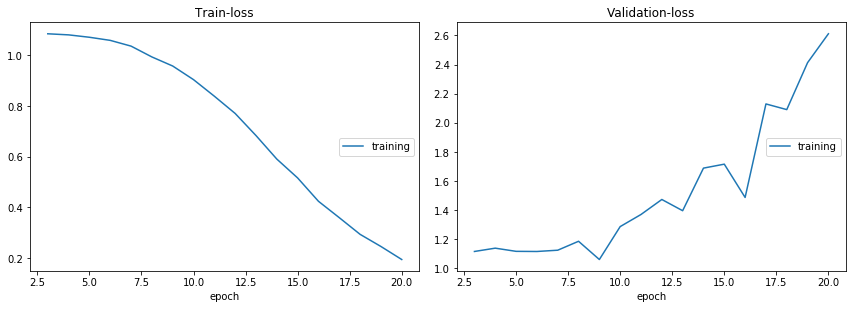

Train-loss:
training   (min:    0.193, max:    1.095, cur:    0.193)

Validation-loss:
training   (min:    1.061, max:    2.611, cur:    2.611)
Epoch: 20



Validation accuracy: 0.25, train loss: 0.12486087801781567 
Val_loss: 2.9522855281829834 




In [ ]:
best_validation_model = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

In [42]:
torch.cuda.empty_cache()